# Import everything that is needed

In [18]:
import cv2
import os
from tqdm import tqdm

# Import scipy libraries
import scipy.io
from skimage import io, transform

# Plotting/Visualization
import matplotlib.pyplot as plt

# Import pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Pre-Process the Videos

In [2]:
# Process videos into frames and save them
data_dir = 'data'
video_path = os.path.join(data_dir, 'videos')
frame_path = os.path.join(data_dir, 'frames')

# If videos directory doesn't exist, then raise an error
if not os.path.exists(video_path): raise ValueError("'data/videos' folder not found.")
videos = [f for f in os.listdir(video_path) if not f.startswith('.')]
if not videos: raise ValueError("No video files found in the 'data/videos' folder.")

# If the frame directory doesn't exist, create it
if not os.path.exists(frame_path):
    os.makedirs(frame_path)

for filename in os.listdir(video_path):
    if filename.startswith('.'): continue
    video_file = os.path.join(video_path, filename)

    # If the folders for the frames doesn't exist, make it
    video_file_name = os.path.join(frame_path, os.path.splitext(filename)[0])
    if not os.path.exists(video_file_name):
        os.makedirs(video_file_name)

    # To keep track of frame count for saving frames
    frameCount = 0

    # Use VideoCapture with the video path
    capture = cv2.VideoCapture(video_file)

    # Get number of frames for visual progress bar
    vid_length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # If the folder already has correct number of frames, don't redo everything
    files = os.listdir(video_file_name)
    file_count = len(files)

    if file_count >= vid_length:
        print(video_file_name, 'has been completed.')
    else:
        for i in tqdm(range(vid_length)):
            success, frame = capture.read()
            if success: cv2.imwrite(os.path.join(video_file_name, "{vidnum}_{framenum:08d}".format(vidnum=filename, framenum=frameCount)+".jpg"), frame)
            else: break
            frameCount = frameCount + 1
        print(video_file_name, 'has been completed.')

    capture.release()

data/frames/P01  has been completed.
data/frames/P02  has been completed.
data/frames/P04  has been completed.
data/frames/P03  has been completed.


In [15]:
# Rename all files to include the video number (because we forgot to do before
# and now we are too lazy to rerun everything)
for frame_dir in os.scandir(frame_path):
    vid_number = frame_dir.name
    if vid_number.startswith('.'): continue
    frames = os.listdir(frame_dir.path)
    if frames[5].startswith(vid_number):
        print(vid_number, 'folder contents already renamed, no need to rename. Please avoid pain.')
    else:
        for file in tqdm(frames):
            if file.startswith('.'): continue
            os.rename(os.path.join(frame_dir.path, file), os.path.join(frame_dir.path, ''.join([vid_number, '_', file])))
        print(vid_number, 'folder contents has been renamed.')

100%|██████████| 161351/161351 [12:32<00:00, 214.52it/s]


P03  folder has been renamed.


100%|██████████| 269103/269103 [31:34<00:00, 142.07it/s] 


P04  folder has been renamed.


100%|██████████| 276859/276859 [26:10<00:00, 176.29it/s] 


P02  folder has been renamed.


100%|██████████| 208667/208667 [26:43<00:00, 130.13it/s]

P01  folder has been renamed.


# Load the dataset

In [36]:
class Dataset(Dataset):
    def __init__(self, dataset_path, sequence_length, transformer=None):
        self.sequnce_length = sequence_length
        self.transform = transformer
        self.sequence_paths = self.__extract_sequence_paths(dataset_path)

    def __extract_sequence_paths(self, dataset_path):
        # Create a list to use for sequence paths
        sequence_list = []
        frame_dirs = [f for f in os.scandir(dataset_path) if f.is_dir() and not filename.startswith('.')]
        for frm_dir in frame_dirs:
            sequence_list = sequence_list + [os.path.join(frm_dir.path, frame_name)
                                             for frame_name
                                             in os.listdir(frm_dir.path) if not frame_name.startswith('.')]
        sequence_list.sort()
        return sequence_list

    def __len__(self):
        return len(self.sequence_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sequence_paths = self.sequence_paths[idx]
        image = io.imread(sequence_paths)
        sample = {'image': image}
        if self.transform:
            sample = self.transform(sample)
        return sample

Text(0.5, 0.98, 'Example images of the dataset')

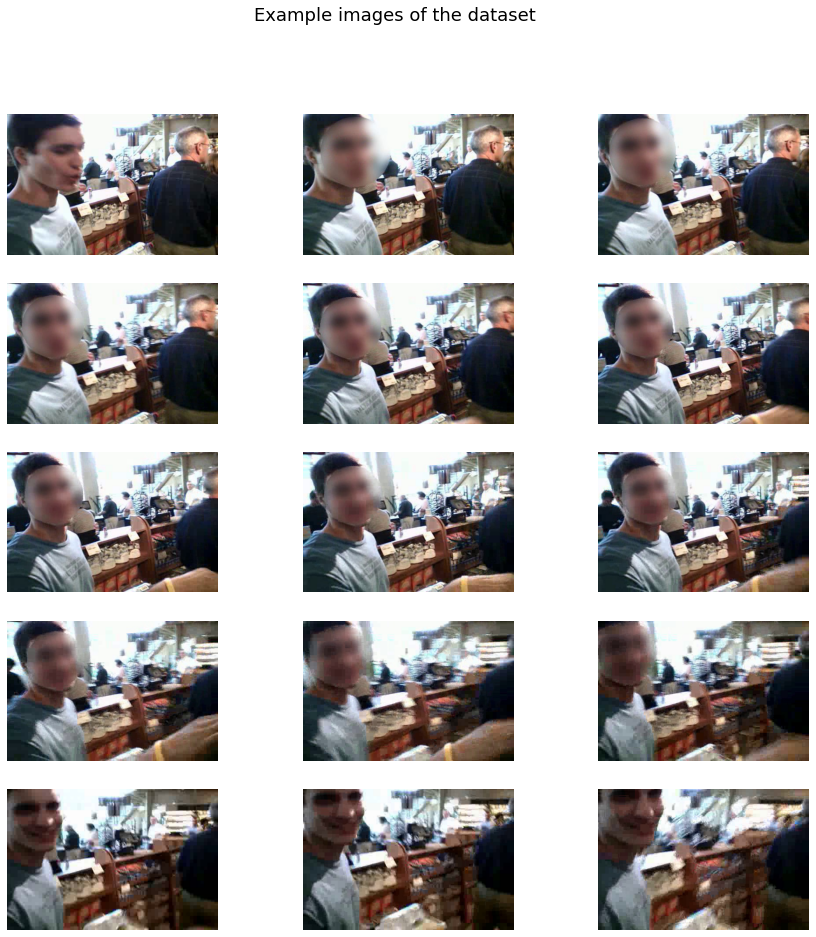

In [37]:
full_dataset = Dataset(dataset_path=frame_path, sequence_length=30)

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# flatten the axis into a 1-d array to make it easier to access each axes
axs = axs.flatten()

# iterate through and enumerate the files, use i to index the axes
for i in range(15):
    sample = full_dataset[i]

    # add the image to the axes
    axs[i].imshow(sample['image'])
    axs[i].axis('off')

# add a figure title
fig.suptitle('Example images of the dataset', fontsize=18)

In [26]:
len(full_dataset)

915980

In [ ]:
# mat = scipy.io.loadmat('data/labels/P01/neg_gtimages/00001636.jpg.mat')
# mat